In [473]:
import pandas as pd
import os

topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'Pilot'
cleandir = os.path.join(topdir, f'data/{study}/Cleaned')
accomodate_path = os.path.join(cleandir, f'{study}Accomodate.csv')
predict_path   = os.path.join(cleandir, f'{study}Predict.csv')

df_accomodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accomodate['task'] = 'accomodate'
df_predict['task']   = 'predict'


print("Accomodate columns:", df_accomodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accomodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'shape_discrete_slider.response', 'color_discrete_slider.response', 'tail_discrete_slider.response', 'shape_direction_slider.response', 'color_direction_slider.response', 'tail_direction_slider.response', 'shape_continuous_slider.response', 'color_continuous_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'training_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'shape_discrete_slider.response', 'color_discrete_slider.response', 

In [ ]:
import ast

food_amount = df_predict['food_amount'].apply(ast.literal_eval)
print(food_amount) # float
print(df_predict['training_image_order'][0][0])


In [475]:
#Combine the dataframes and create an arbitrary column for participant numbering (the yoked orders are already stored in 'conditionOrder')
df_combined = pd.concat([df_accomodate, df_predict], ignore_index=True)
df_combined['participant'] = range(1, len(df_combined) + 1)


In [476]:
#Look at average time across task
df_combined['trial_stop_time'].describe()
avg_time = df_combined.groupby(['task'])['trial_stop_time'].mean()
print(avg_time)

task
accomodate    542.201817
predict       520.177030
Name: trial_stop_time, dtype: float64


In [477]:
#Timing without highest accomodate outlier (used in version of script where this occurred)
df_no_outliers = df_combined[df_combined['trial_stop_time'] != df_combined['trial_stop_time'].max()]
avg_time = df_no_outliers.groupby('task')['trial_stop_time'].mean()
print(avg_time)

task
accomodate    512.943207
predict       520.177030
Name: trial_stop_time, dtype: float64


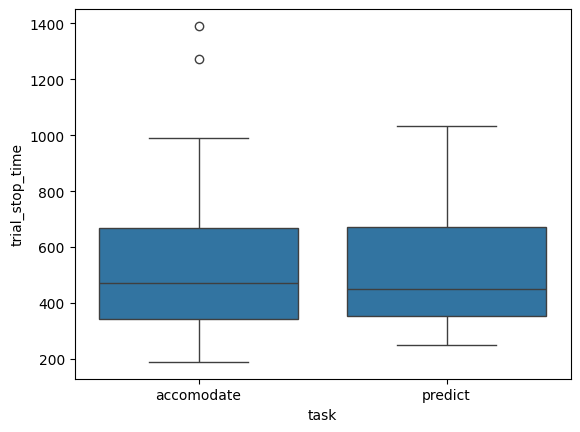

In [478]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=df_combined, x='task', y='trial_stop_time')
plt.show()

In [2]:
import ast
import matplotlib.pyplot as plt
#Calculate actual food amounts over the trials during training
def AverageFoodCalclatorTrain(participants_to_use):
    df_subset = df_combined[df_combined['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        trial_order = ast.literal_eval(df_subset[df_subset['participant'] == i]['training_image_order'].iloc[0])
        food_amount = ast.literal_eval(df_subset[df_subset['participant'] == i]['food_amount'].iloc[0])
        print(food_amount[0])
        categories = ast.literal_eval(df_subset[df_subset['participant'] == i]['training_categories'].iloc[0])



        
        task = df_subset[df_subset['participant'] == i]['task'].iloc[0]
        df_participant = pd.DataFrame(list(zip(
            [i]*len(trial_order),  # Repeat participant ID and task to match the number of ratings
            trial_order,
            food_amount,
            [task]*len(trial_order), # Repeat participant ID and task to match the number of ratings
            categories,
        )), columns=['participant', 'image', 'food_amount', 'task', 'category'])
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings_cond = df_average.groupby(['task', 'category'])['food_amount'].mean()
    avg_ratings_image = df_average.groupby(['task', 'image', 'category'])['food_amount'].mean()
    return df_average, avg_ratings_cond, avg_ratings_image

participants_to_use = df_combined['participant'].tolist()
df_average_test, avg_rating_cond, avg_rating_image = AverageFoodCalclatorTrain(participants_to_use)
print(avg_rating_cond)
print(avg_rating_image)




NameError: name 'df_combined' is not defined

In [ ]:
import ast
import matplotlib.pyplot as plt
#Calculate reported food amounts during testing
def AverageFoodCalclator(participants_to_use):
    df_subset = df_combined[df_combined['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        trial_order = ast.literal_eval(df_subset[df_subset['participant'] == i]['testing_image_order'].iloc[0])
        ratings     = ast.literal_eval(df_subset[df_subset['participant'] == i]['testing_responses'].iloc[0])
        categories = ast.literal_eval(df_subset[df_subset['participant'] == i]['testing_categories'].iloc[0])
        task = df_subset[df_subset['participant'] == i]['task'].iloc[0]
        row = df_subset[df_subset['participant'] == i].iloc[0]
        tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
        shape_yes = 1 if row['shape_discrete_slider.response'] == 'Yes' else 0
        color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0
        num_features_relevant = tail_yes + shape_yes + color_yes
        df_participant = pd.DataFrame(list(zip(
            [i]*len(trial_order),  # Repeat participant ID and task to match the number of ratings
            trial_order,
            ratings,
            [task]*len(trial_order), # Repeat participant ID and task to match the number of ratings
            categories,
            [num_features_relevant]*len(trial_order)
        )), columns=['participant', 'image', 'ratings', 'task', 'category', 'num_features_relevant'])
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings_cond = df_average.groupby(['task', 'category'])['ratings'].mean()
    avg_ratings_image = df_average.groupby(['task', 'image', 'category'])['ratings'].mean()
    return df_average, avg_ratings_cond, avg_ratings_image

participants_to_use = df_combined['participant'].tolist()
df_average, avg_rating_cond, avg_rating_image = AverageFoodCalclator(participants_to_use)
print(avg_rating_cond)
print(avg_rating_image)




task        category
accomodate  high        6.500000
            low         4.016667
            medium      5.408333
predict     high        6.216667
            low         4.483333
            medium      5.250000
Name: ratings, dtype: float64
task        image  category
accomodate  N_B_C  low         4.133333
            N_B_S  medium      5.533333
            N_Y_C  low         3.900000
            N_Y_S  medium      5.133333
            T_B_C  medium      5.666667
            T_B_S  high        6.500000
            T_Y_C  medium      5.300000
            T_Y_S  high        6.500000
predict     N_B_C  low         4.400000
            N_B_S  medium      5.866667
            N_Y_C  low         4.566667
            N_Y_S  medium      5.000000
            T_B_C  medium      5.200000
            T_B_S  high        6.566667
            T_Y_C  medium      4.933333
            T_Y_S  high        5.866667
Name: ratings, dtype: float64


In [481]:
# Group by task, category, and num_features_relevant
avg_ratings_cond_by_relevance = df_average.groupby(
    ['task', 'category', 'num_features_relevant']
)['ratings'].mean().reset_index()



In [482]:
category_order = ['low', 'medium', 'high']
avg_ratings_cond_by_relevance['category'] = pd.Categorical(
    avg_ratings_cond_by_relevance['category'],
    categories=category_order,
    ordered=True
)

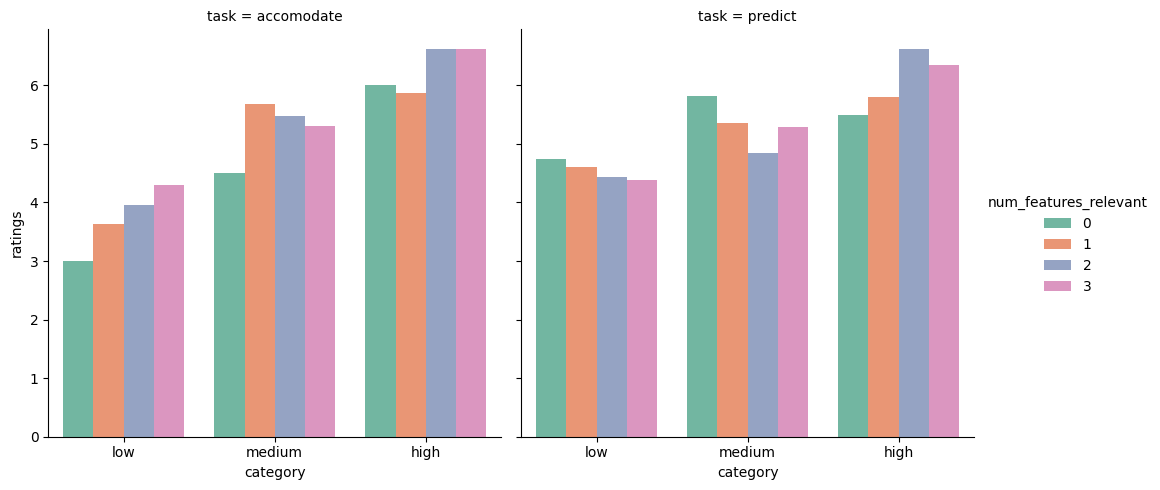

In [483]:
sns.catplot(
    data=avg_ratings_cond_by_relevance,
    x='category', y='ratings',
    hue='num_features_relevant', col='task',
    kind='bar', palette='Set2'
)
plt.savefig(f'{study}Plots/FeatureRelevantPerformance.png', bbox_inches='tight')

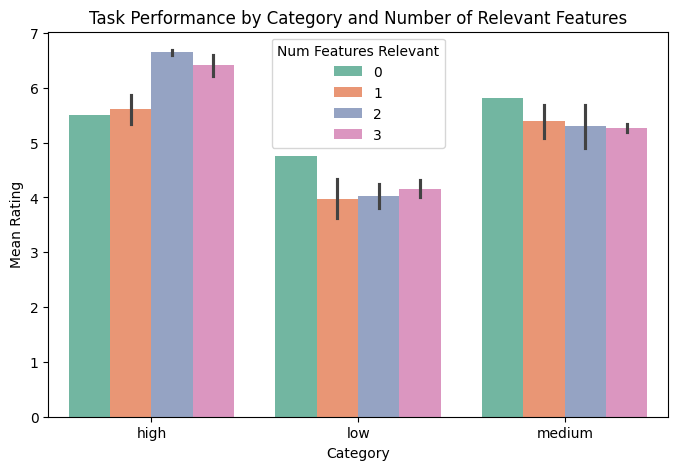

In [448]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    data=avg_ratings_cond_by_relevance,
    x='category',
    y='ratings',
    hue='num_features_relevant',
    palette='Set2'
)

plt.xlabel("Category")
plt.ylabel("Mean Rating")
plt.title("Task Performance by Category and Number of Relevant Features")
plt.legend(title="Num Features Relevant")
plt.show()


In [ ]:
#Look at differences in ratings for the irrelevant feature
df_avg = df_average.copy()
df_avg['color'] = df_avg['image'].apply(lambda x: x.split('_')[1])
mean_by_color = (
    df_avg.groupby(['task', 'color'])['ratings']
          .mean()
          .unstack()     # puts Y and C in columns
)
print(mean_by_color)
mean_by_color['overall difference'] = mean_by_color['Y'] - mean_by_color['B']
print(mean_by_color)


color              B         Y
task                          
accomodate  5.652174  5.206522
predict     5.464286  4.857143
color              B         Y  overall difference
task                                              
accomodate  5.652174  5.206522           -0.445652
predict     5.464286  4.857143           -0.607143


<Axes: xlabel='category', ylabel='ratings'>

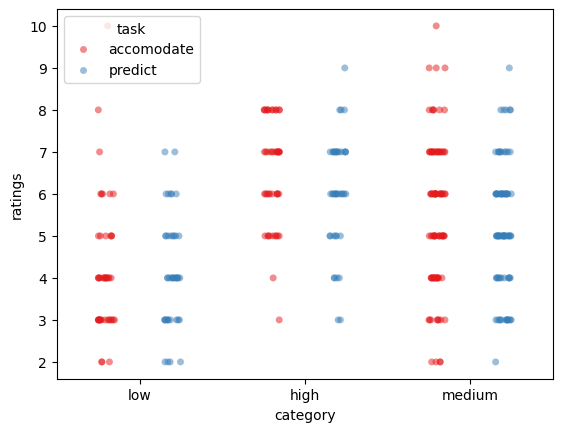

In [420]:
import seaborn as sns
sns.stripplot(data=df_average, x='category', y='ratings', hue='task', 
              palette='Set1', dodge=True, jitter=True, color='black', alpha=0.5)
#plt.savefig('PrePilotPlots/CategoryStripPlot.png')


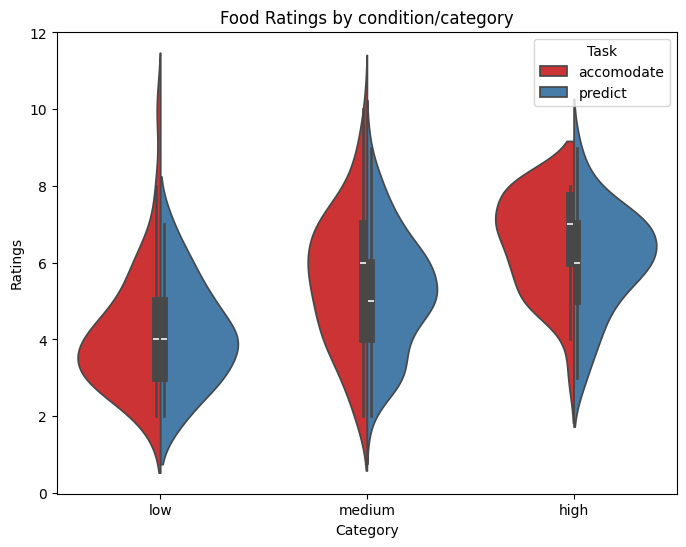

In [421]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ['low', 'medium', 'high']
# Violin plot: ratings by category, separated by task
plt.figure(figsize=(8,6))
sns.violinplot(
    data=df_average,
    x='category',       # x-axis: categories
    y='ratings',        # y-axis: ratings
    hue='task',         # split by task
    split=True,         # split the violins by task
    palette='Set1',
    inner='box',    # show box plot of data inside
    order = order
)

plt.ylabel('Ratings')
plt.xlabel('Category')
plt.title('Food Ratings by condition/category')
plt.legend(title='Task')
#plt.savefig(f'{study}Plots/ViolinRatings.png', bbox_inches='tight')
plt.show()

In [422]:
import ast
import pandas as pd

food_amount_lists = df_predict['food_amount'].apply(ast.literal_eval)
order_lists = df_predict['training_image_order'].apply(ast.literal_eval)

tmp = pd.DataFrame({
    'type': order_lists.explode(),
    'food': food_amount_lists.explode()
})

# Convert food to float
tmp['food'] = tmp['food'].astype(float)

# Compute mean food per type
avg_food_per_type = tmp.groupby('type')['food'].mean()

print(avg_food_per_type)


type
N_B_C    2.852941
N_B_S    4.848485
N_Y_C    3.059701
N_Y_S    4.781250
T_B_C    5.378788
T_B_S    7.234375
T_Y_C    4.609375
T_Y_S    6.303030
Name: food, dtype: float64


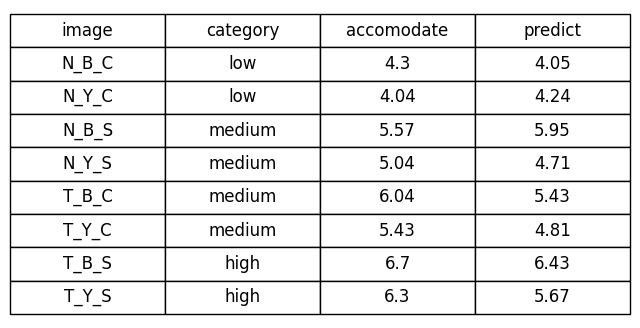

In [423]:
category_order = ['low', 'medium', 'high']
df_table = avg_rating_image.unstack(level=0).reset_index().round(2)
df_table['category'] = pd.Categorical(df_table['category'], categories=category_order, ordered=True)
df_table = df_table.sort_values('category').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,4))
ax.axis('off')  # no axes for a table

# create table
tbl = ax.table(cellText=df_table.values,
               colLabels=df_table.columns,
               cellLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 2)  # scale width and height

#plt.savefig(f'{study}Plots/AverageRatingsTable.png', bbox_inches='tight')
plt.show()

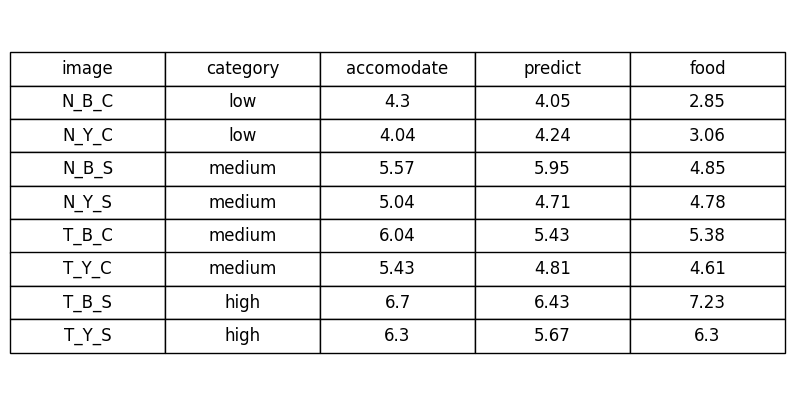

In [424]:
import ast
import pandas as pd

# --- Compute mean food per image type (already done) ---
food_amount_lists = df_predict['food_amount'].apply(ast.literal_eval)
order_lists = df_predict['training_image_order'].apply(ast.literal_eval)

tmp = pd.DataFrame({
    'image': order_lists.explode().reset_index(drop=True),
    'food': food_amount_lists.explode().reset_index(drop=True)
})

tmp['food'] = tmp['food'].astype(float)

# Compute mean food per image
avg_food_per_type = tmp.groupby('image')['food'].mean().reset_index().round(2)
# columns: ['image', 'food']

# --- Prepare table ---
category_order = ['low', 'medium', 'high']
df_table = avg_rating_image.unstack(level=0).reset_index().round(2)

# Merge avg_food_per_type by image so it aligns correctly
df_table = df_table.merge(avg_food_per_type, left_on='image', right_on='image', how='left')

# Add categorical ordering
df_table['category'] = pd.Categorical(df_table['category'], categories=category_order, ordered=True)
df_table = df_table.sort_values('category').reset_index(drop=True)

# --- Plot table ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')  # no axes for a table

tbl = ax.table(cellText=df_table.values,
               colLabels=df_table.columns,
               cellLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 2)

plt.show()


In [405]:
####CHECK SLIDER RESPONSES (SUBJECTIVE REPORTS OF RELEVANCE)



'shape_discrete_slider.response',
'color_discrete_slider.response',
'tail_discrete_slider.response',
'shape_direction_slider.response',
'color_direction_slider.response',
'tail_direction_slider.response',
'shape_continuous_slider.response',
'color_continuous_slider.response',
'tail_continuous_slider.response'

# Counters for how many participants said each feature is relevant
predict_total = {"tail": 0, "shape": 0, "color": 0}

# If you want total relevant features per participant, collect them
participant_totals = {}

for i in df_predict['participant']:

    tail_int = df_predict.loc[df_predict['participant'] == i, 
                              'tail_discrete_slider.response'].iloc[0]
    shape_int = df_predict.loc[df_predict['participant'] == i, 
                               'shape_discrete_slider.response'].iloc[0]
    color_int = df_predict.loc[df_predict['participant'] == i, 
                               'color_discrete_slider.response'].iloc[0]

    # Convert "Yes"/"No" → integer 1/0
    tail_yes  = 1 if tail_int == 'Yes' else 0
    shape_yes = 1 if shape_int == 'Yes' else 0
    color_yes = 1 if color_int == 'Yes' else 0

    # Count relevance across all participants
    predict_total["tail"]  += tail_yes
    predict_total["shape"] += shape_yes
    predict_total["color"] += color_yes

    # Count number of relevant features *for this participant*
    participant_totals[i] = tail_yes + shape_yes + color_yes

print(predict_total)
print(participant_totals)



{'tail': 7, 'shape': 7, 'color': 6}
{6: 2, 9: 3, 10: 3, 7: 2, 3: 3, 27: 2, 19: 3, 20: 1, 4: 1}


3     3
4     1
6     2
7     2
9     3
10    3
19    3
20    1
27    2
Name: num_relevant_features, dtype: int64


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_52149/2809480682.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].replace({'Yes': 1, 'No': 0})


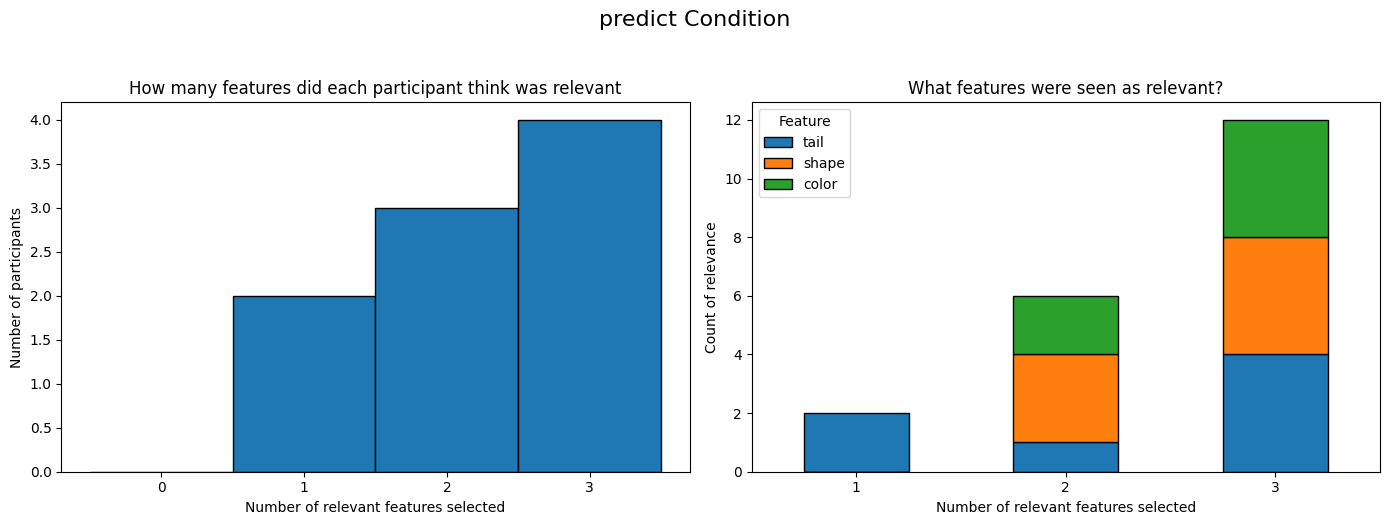

In [410]:
def relevance_counts(relevant_df, condition):
    #Takes in a df assigned to a condition, and computes 
    #1. the counts of participants saying 'yes' to the relevance of the features
    # Count relevant features per participant
    participant_totals = {}
    #count 'yes' responses to each feature by participant
    for i, row in relevant_df.groupby("conditionOrder").first().iterrows():
        tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
        shape_yes = 1 if row['shape_discrete_slider.response'] == 'Yes' else 0
        color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0
        participant_totals[i] = tail_yes + shape_yes + color_yes

    #crease new pandas series with the data
    counts = pd.Series(participant_totals, name="num_relevant_features")
    print(counts)

    #Group by participant and get numbers in place of yes and no
    df_features = relevant_df.groupby("conditionOrder").first()[[
    'tail_discrete_slider.response',
    'shape_discrete_slider.response',
    'color_discrete_slider.response'
    ]].replace({'Yes': 1, 'No': 0})
    df_features.columns = ['tail', 'shape', 'color']
    df_features.columns = ['tail', 'shape', 'color']

    # Get sum of what features were said to be relevant
    df_features['num_relevant'] = df_features.sum(axis=1)
    breakdown = df_features.groupby('num_relevant')[['tail','shape','color']].sum()
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    #Histogram of total counts of how many features were relevant
    axes[0].hist(counts, bins=[-0.5,0.5,1.5,2.5,3.5], edgecolor="black")

    axes[0].set_xticks([0,1,2,3])
    axes[0].set_xlabel("Number of relevant features selected")
    axes[0].set_ylabel("Number of participants")
    axes[0].set_title("How many features did each participant think was relevant")

    #Breakdown of what features were thought to be relevant
    breakdown.plot(
        kind='bar',
        stacked=True,
        ax=axes[1],  
        edgecolor="black"
    )

    axes[1].set_xlabel("Number of relevant features selected")
    axes[1].set_ylabel("Count of relevance")
    axes[1].set_title("What features were seen as relevant?")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    axes[1].legend(title="Feature")
    fig.suptitle(f"{condition} Condition", fontsize=16, y=1.04)
    plt.tight_layout()
    #plt.savefig(f'{study}Plots/FeatureRelevance({condition}).png', bbox_inches='tight')
    plt.show()
    
relevance_counts(df_predict, 'predict')


In [429]:
print(df_average)

     participant  image  ratings        task category
0              1  N_Y_C      6.0  accomodate      low
1              1  T_B_S      8.0  accomodate     high
2              1  T_Y_S      7.0  accomodate     high
3              1  N_Y_S      8.0  accomodate   medium
4              1  T_Y_C      5.0  accomodate   medium
..           ...    ...      ...         ...      ...
347           44  T_B_C      5.0     predict   medium
348           44  N_Y_S      7.0     predict   medium
349           44  N_B_C      4.0     predict      low
350           44  T_Y_C      6.0     predict   medium
351           44  T_B_S      7.0     predict     high

[352 rows x 5 columns]


In [426]:
# From your relevance_counts logic
for i, row in df_combined.groupby("conditionOrder").first().iterrows():
    print(f"conditionOrder: {i}, participant: {row['participant']}")


conditionOrder: 1, participant: 39
conditionOrder: 2, participant: 6
conditionOrder: 3, participant: 15
conditionOrder: 4, participant: 3
conditionOrder: 5, participant: 28
conditionOrder: 6, participant: 18
conditionOrder: 7, participant: 2
conditionOrder: 8, participant: 5
conditionOrder: 9, participant: 9
conditionOrder: 10, participant: 16
conditionOrder: 11, participant: 23
conditionOrder: 12, participant: 22
conditionOrder: 13, participant: 17
conditionOrder: 14, participant: 19
conditionOrder: 15, participant: 21
conditionOrder: 16, participant: 20
conditionOrder: 17, participant: 38
conditionOrder: 18, participant: 1
conditionOrder: 20, participant: 4
conditionOrder: 21, participant: 37
conditionOrder: 22, participant: 25
conditionOrder: 23, participant: 11
conditionOrder: 24, participant: 10
conditionOrder: 25, participant: 41
conditionOrder: 26, participant: 12
conditionOrder: 27, participant: 7
conditionOrder: 28, participant: 13
conditionOrder: 29, participant: 8
conditionO

In [381]:
import pandas as pd

direction_map = {
    "Blue": 1,
    "Yellow": -1,
    "Square": 1,
    "Circular": -1,
    "Having a tail": 1,
    "Having no tail": -1,

}

features = ["shape", "color", "tail"]

def compute_distribution(df):
    results = {f: [] for f in features}
    results["conditionOrder"] = []   # keep condition order per participant

    for idx, row in df.iterrows():
        conditionOrder = row["conditionOrder"]  

        for f in features:
            discrete = row[f"{f}_discrete_slider.response"]
            direction = row[f"{f}_direction_slider.response"]
            continuous = row[f"{f}_continuous_slider.response"]

            if discrete == "No":
                score = 0
            else:
                sign = direction_map.get(direction, 0)
                score = sign * float(continuous)

            results[f].append(score)

        # condition_order should be added once per row
        results["conditionOrder"].append(conditionOrder)

    return pd.DataFrame(results)


dist_predict = compute_distribution(df_predict)
dist_accomodate = compute_distribution(df_accomodate)

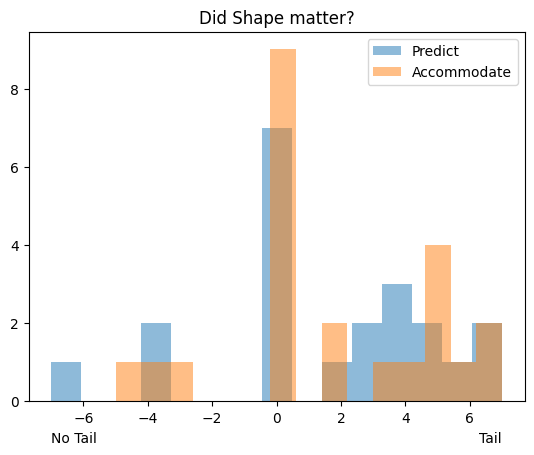

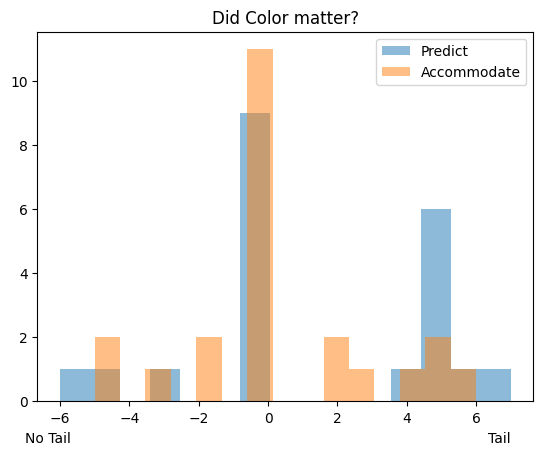

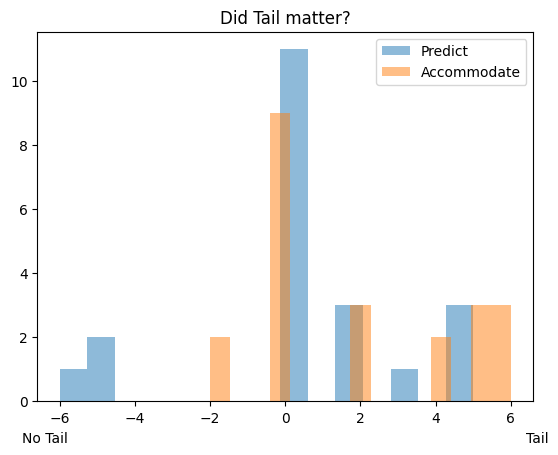

In [383]:
for f in features:
    plt.hist(dist_predict[f], bins=15, alpha=0.5, label="Predict")
    plt.hist(dist_accomodate[f], bins=15, alpha=0.5, label="Accommodate")
    plt.title(f"Did {f.capitalize()} matter?")
    plt.annotate("No Tail", xy=(-7, -0.08), xycoords=('data', 'axes fraction'),
             ha='left', va='top')
    plt.annotate("Tail", xy=(7, -0.08), xycoords=('data', 'axes fraction'),
             ha='right', va='top')
    plt.legend()
    plt.savefig(f'{study}Plots/-7to7({f}).png', bbox_inches='tight')
    plt.show()

In [386]:
import ast

list_cols = ['training_tail', 'training_shape', 'training_color', 'training_categories', 'food_amount']
for col in list_cols:
    df_predict[col] = df_predict[col].apply(ast.literal_eval)



In [387]:
for col in list_cols:
    df_accomodate[col] = df_accomodate[col].apply(ast.literal_eval)

In [388]:
for feat in ['training_tail', 'training_shape', 'training_color']:
    all_letters = list(itertools.chain.from_iterable(df_accomodate[feat]))
    unique_letters = set(all_letters)
    print(f"{feat} unique letters:", unique_letters)


training_tail unique letters: {'T', 'N'}
training_shape unique letters: {'C', 'S'}
training_color unique letters: {'B', 'Y'}


In [389]:
import ast
import numpy as np
import pandas as pd

def compute_true_associations(row):
    result = {}

    # binary mappings for each feature list
    mapping = {
        "tail": {"T": 1, "N": 0},
        "shape": {"S": 1, "C": 0},  
        "color": {"B": 1, "Y": 0}
    }

    # Ensure food_amount is a proper list of numbers
    if isinstance(row["food_amount"], str):
        food_list = ast.literal_eval(row["food_amount"])
    else:
        food_list = row["food_amount"]
        
    food = np.array(food_list, dtype=float)

    for feat in ["tail", "shape", "color"]:
        vals = np.array([mapping[feat][x] for x in row[f"training_{feat}"]])

        mean1 = food[vals == 1].mean()
        mean0 = food[vals == 0].mean()

        true_assoc = mean1 - mean0  # positive = feature-value-1 associates with higher food

        result[f"true_{feat}"] = true_assoc

    return pd.Series(result)

# Apply to the dataframe
true_assoc_df = df_predict.apply(compute_true_associations, axis=1)
true_assoc_accom = df_accomodate.apply(compute_true_associations, axis=1)


In [390]:
analysis_predict = pd.concat([dist_predict, true_assoc_df], axis=1)
analysis_accomodate = pd.concat([dist_accomodate, true_assoc_accom], axis=1)

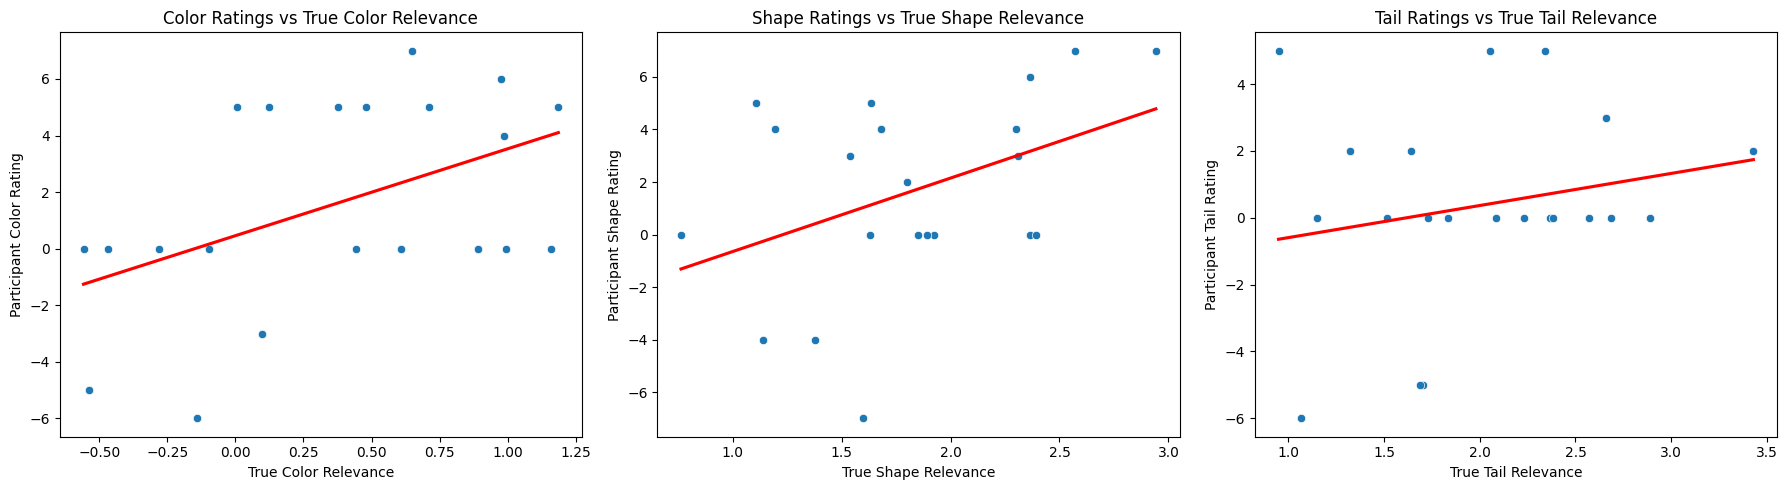

In [393]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['color', 'shape', 'tail']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for ax, feat in zip(axes, features):
    sns.scatterplot(x=f'true_{feat}', y=feat, data=analysis_predict, ax=ax)
    sns.regplot(x=f'true_{feat}', y=feat, data=analysis_predict, scatter=False, ci=None, color='red', ax=ax)
    ax.set_xlabel(f"True {feat.capitalize()} Relevance")
    ax.set_ylabel(f"Participant {feat.capitalize()} Rating")
    ax.set_title(f"{feat.capitalize()} Ratings vs True {feat.capitalize()} Relevance")

plt.tight_layout()
plt.savefig(f'{study}Plots/Correlations(predict).png', bbox_inches='tight')
plt.show()


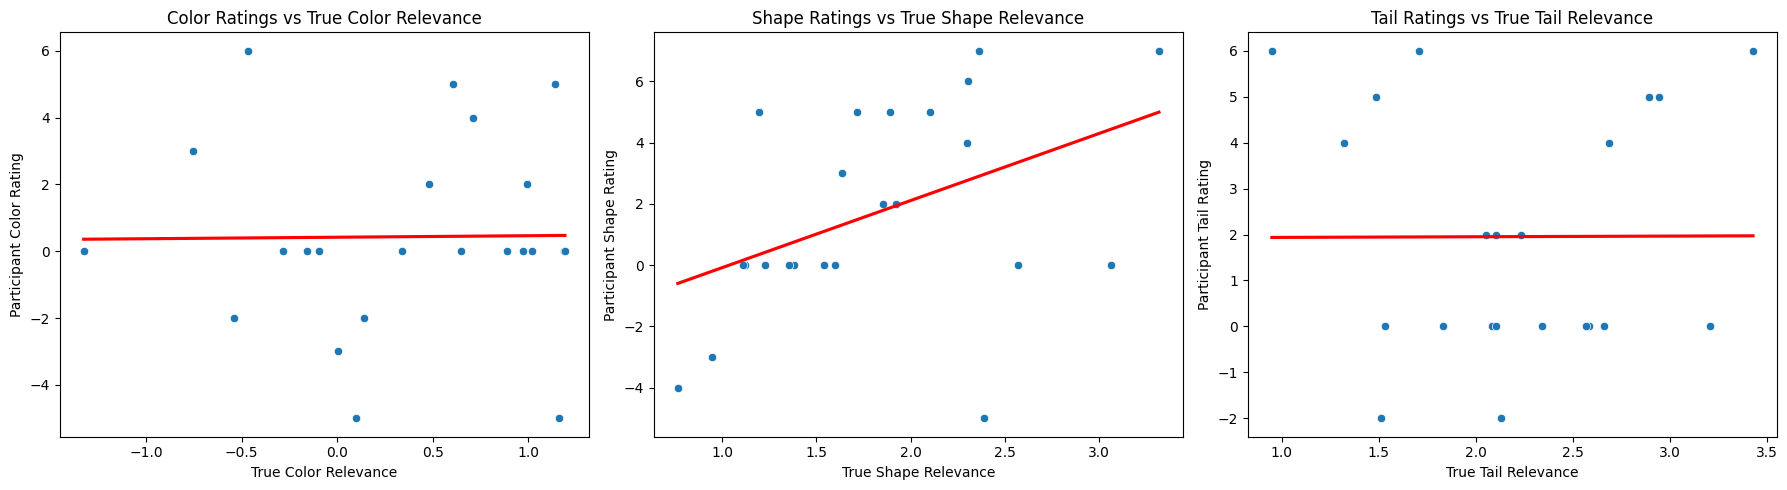

In [394]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['color', 'shape', 'tail']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for ax, feat in zip(axes, features):
    sns.scatterplot(x=f'true_{feat}', y=feat, data=analysis_accomodate, ax=ax)
    sns.regplot(x=f'true_{feat}', y=feat, data=analysis_accomodate, scatter=False, ci=None, color='red', ax=ax)
    ax.set_xlabel(f"True {feat.capitalize()} Relevance")
    ax.set_ylabel(f"Participant {feat.capitalize()} Rating")
    ax.set_title(f"{feat.capitalize()} Ratings vs True {feat.capitalize()} Relevance")

plt.tight_layout()
plt.savefig(f'{study}Plots/Correlations(accommodate)x.png', bbox_inches='tight')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['color', 'shape', 'tail']

for feat in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=f'true_{feat}', y=feat, data=analysis_accomodate)
    sns.regplot(x=f'true_{feat}', y=feat, data=analysis_accomodate, scatter=False, ci=None, color='red')
    plt.xlabel(f"True {feat.capitalize()} Relevance")
    plt.ylabel(f"Participant {feat.capitalize()} Rating")
    plt.title(f"{feat.capitalize()} Ratings vs True {feat.capitalize()} Relevance Across Participants")
    plt.show()


OLD (check last trials influence)

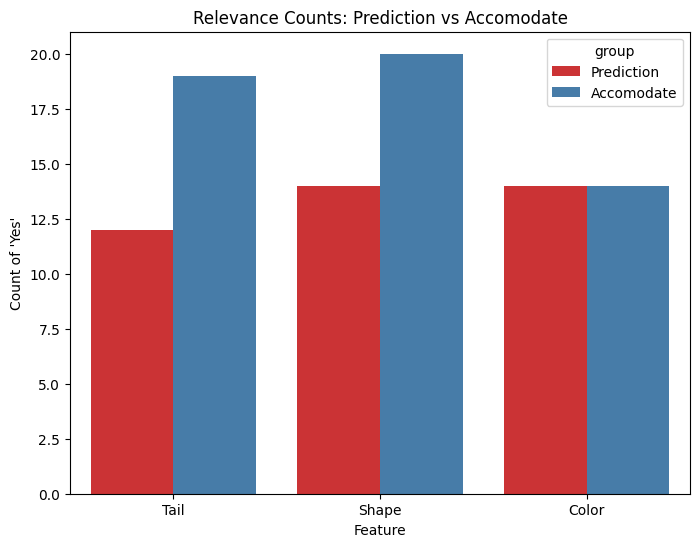

In [379]:
def compute_relevance(df):
    return {
        "tail":   (df['tail_discrete_slider.response']  == 'Yes').sum(),
        "shape":  (df['shape_discrete_slider.response'] == 'Yes').sum(),
        "color":  (df['color_discrete_slider.response'] == 'Yes').sum()
    }
pred_counts = compute_relevance(df_predict)
acc_counts  = compute_relevance(df_accomodate)
import pandas as pd

df_counts = pd.DataFrame([
    {"group": "Prediction",  "feature": "Tail",  "count": pred_counts["tail"]},
    {"group": "Prediction",  "feature": "Shape", "count": pred_counts["shape"]},
    {"group": "Prediction",  "feature": "Color", "count": pred_counts["color"]},
    {"group": "Accomodate",  "feature": "Tail",  "count": acc_counts["tail"]},
    {"group": "Accomodate",  "feature": "Shape", "count": acc_counts["shape"]},
    {"group": "Accomodate",  "feature": "Color", "count": acc_counts["color"]},
])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.barplot(
    data=df_counts,
    x="feature",
    y="count",
    hue="group",
    palette="Set1"
)

plt.title("Relevance Counts: Prediction vs Accomodate")
plt.ylabel("Count of 'Yes'")
plt.xlabel("Feature")
plt.show()




In [61]:
import ast
import numpy as np
import pandas as pd

def check_last_n_influence(participant_row, n_last=3):
    """
    Check how the last N training items (food_amount) influence the ratings
    given to those items by the participant.
    """
    # Convert stringified lists
    food_amounts = ast.literal_eval(participant_row['food_amount'])
    training_images = ast.literal_eval(participant_row['training_image_order'])
    ratings = ast.literal_eval(participant_row['ratings'])
    rated_images = ast.literal_eval(participant_row['image_order'])
    
    # Last n items from training
    last_food_amounts = food_amounts[-n_last:]
    last_training_images = training_images[-n_last:]
    
    # Find indices in rated_images corresponding to last training images
    indices_in_rated = [rated_images.index(img) for img in last_training_images]
    print(indices_in_rated)
    corresponding_ratings = [ratings[i] for i in indices_in_rated]
    
    # Print for inspection
    print(f"Participant {participant_row['participant']}")
    print("Last N food amounts:", last_food_amounts)
    print("Corresponding training images:", last_training_images)
    print("Ratings given for these images:", corresponding_ratings)
    print("-"*40)
    
    return last_food_amounts, corresponding_ratings

# Loop over all participants
results = []
for idx, row in df_combined.iterrows():
    last_food, last_ratings = check_last_n_influence(row, n_last=3)
    results.append({
        'participant': row['participant'],
        'last_food': last_food,
        'last_ratings': last_ratings
    })

# Convert to DataFrame if desired
df_last_n_influence = pd.DataFrame(results)
print(df_last_n_influence)


[2, 7, 2]
Participant 1
Last N food amounts: [6.0, 4.0, 2.0]
Corresponding training images: ['N_B_C', 'N_Y_S', 'N_B_C']
Ratings given for these images: [3.0, 7.0, 3.0]
----------------------------------------
[3, 0, 7]
Participant 2
Last N food amounts: [6.0, 1.0, 10.0]
Corresponding training images: ['T_B_C', 'N_Y_C', 'T_Y_S']
Ratings given for these images: [7.0, 4.0, 6.0]
----------------------------------------
[2, 5, 4]
Participant 3
Last N food amounts: [6.0, 7.0, 2.0]
Corresponding training images: ['T_B_C', 'N_Y_S', 'N_Y_C']
Ratings given for these images: [6.0, 8.0, 7.0]
----------------------------------------
[0, 7, 5]
Participant 4
Last N food amounts: [6.0, 5.0, 1.0]
Corresponding training images: ['T_Y_S', 'T_Y_C', 'N_B_C']
Ratings given for these images: [7.0, 5.0, 2.0]
----------------------------------------
[7, 3, 0]
Participant 5
Last N food amounts: [2.0, 5.0, 8.0]
Corresponding training images: ['N_B_C', 'T_B_C', 'T_Y_S']
Ratings given for these images: [5.0, 7.0, 